## Imports

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import glob
import argparse
import json
import math
import colorsys

#import config
#import tfutil
#import dataset
import networks2
import loss
from train import *
#import misc
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical, plot_model
#import tensorflow_datasets as tfds

from PIL import Image


import pickle
#import optuna

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')

# print(physical_devices)

# tf.config.set_logical_device_configuration(physical_devices[0],[tf.config.LogicalDeviceConfiguration(memory_limit=1000),tf.config.LogicalDeviceConfiguration(memory_limit=1000)])

# logical_devices = tf.config.list_logical_devices('GPU')
# print(logical_devices)

# try:
#     tf.config.set_logical_device_configuration(
#         physical_devices[0],
#         [tf.config.LogicalDeviceConfiguration(),
#         tf.config.LogicalDeviceConfiguration()])

#     logical_devices = tf.config.list_logical_devices('GPU')
#     print(logical_devices)
# #   assert len(logical_devices) == len(physical_devices) + 1

# #   tf.config.set_logical_device_configuration(
# #     physical_devices[0],
# #     [tf.config.LogicalDeviceConfiguration(memory_limit=10),
# #      tf.config.LogicalDeviceConfiguration(memory_limit=10)])
# except:
#     # Invalid device or cannot modify logical devices once initialized.
#     print("Fail")
#     pass



In [ ]:
datapath = '/eos/user/r/redacost/progan/tfrecords1024/'
tfrecord_dir = datapath
tfr_files = sorted(glob.glob(os.path.join(tfrecord_dir, '*.tfrecords')))
minibatch_base = 32
minibatch_dict = {4: 1024, 8: 512, 16: 256, 32: 64, 64: 64, 128: 32}
max_minibatch_per_gpu = {256: 16, 512: 8, 1024: 8}
dataset_list, batch_sizes_list = get_dataset(tfr_files, num_gpus=1, minibatch_base = minibatch_base, minibatch_dict = minibatch_dict, max_minibatch_per_gpu = max_minibatch_per_gpu, repeat = False, shuffle_mb=0,prefetch_mb=0)
lod_dataset = 0
dataset = dataset_list[lod_dataset]
print(dataset)

dataset_iter = iter(dataset)
min = 255 #0
max = 0 #242

r_l = [0] * 256
g_l = [0] * 256
b_l = [0] * 256

n_images = 600
for i in range(n_images):
    dataset_el = next(dataset_iter).numpy()[0]
    # dataset_el = dataset_el.flatten()
    # for el in dataset_el:
    #     l[el] = l[el] + 1
    r = dataset_el[0].flatten()
    for el in r:
        r_l[el] = r_l[el] + 1
    g = dataset_el[1].flatten()
    for el in g:
        g_l[el] = g_l[el] + 1
    b = dataset_el[2].flatten()
    for el in b:
        b_l[el] = b_l[el] + 1
    # d_min = np.amin(dataset_el)
    # if d_min < min:
    #     min = d_min
    #     print("min: " + str(min))
    # d_max = np.amax(dataset_el)
    # if d_max > max:
    #     max = d_max
    #     print("max: " + str(max))

    if i % 100 == 0:
        print(i)
        #print(dataset_el)
        #print(dataset_el.size)

#fig.savefig("color_hystogram.png")

In [ ]:
print(r.shape)

r_l = np.array(r_l)
#print(r_l)
r_cdf = np.cumsum(r_l)

#print(r_cdf)

r_test_image = next(dataset_iter).numpy()[0][0]
o_r_test_image = np.copy(r_test_image)

r_dataset_el_test = np.array(np.histogram(r_test_image, bins=256)[0])
print(r_dataset_el_test.shape)
r_cdf = np.cumsum(r_dataset_el_test)
print(r_cdf)

print(o_r_test_image)

h = np.round((r_cdf - r_cdf[0]) / (256*256 - r_cdf[0]) * 255)

print(h)

for i, el in enumerate(r_test_image):
    r_test_image[i] = h[el]

print(r_test_image)


In [ ]:
#data = np.array(l)
#print(l)

bins = np.linspace(0, 255,256) # fixed number of bins
#print(bins)

fig, ax = plt.subplots()

plt.xlim([0, 256+5])
plt.ylim([0,70000])

print(np.histogram(r_test_image, bins=256)[0])

plt.bar(bins, np.histogram(r_test_image, bins=256)[0], color ='r')
plt.title('Red color distribution')
plt.xlabel('Pixel Value')
plt.ylabel('count')

r_cdf = np.cumsum(np.histogram(r_test_image, bins=256)[0])

plt.plot(r_cdf)

plt.show()

o_r_test_image

plt.bar(bins, np.histogram(o_r_test_image, bins=256)[0], color ='r')
plt.title('Red color distribution')
plt.xlabel('Pixel Value')
plt.ylabel('count')

r_cdf = np.cumsum(np.histogram(o_r_test_image, bins=256)[0])

print(r_cdf)

plt.plot(r_cdf)

plt.show()

#plt.show()



In [ ]:

fig, ax = plt.subplots()

plt.xlim([0, 256+5])
#plt.ylim([0, 10000000])

plt.bar(bins, g_l, color='g')
plt.title('Green color distribution')
plt.xlabel('Pixel Value')
plt.ylabel('count')

plt.show()

In [ ]:
fig, ax = plt.subplots()

plt.xlim([0, 256+5])
#plt.ylim([0, 10000000])

plt.bar(bins, b_l)
plt.title('Blue color distribution')
plt.xlabel('Pixel Value')
plt.ylabel('count')

plt.show()

In [ ]:
fig, ax = plt.subplots()

plt.xlim([0, 256+5])
#plt.ylim([0, 10000000])

plt.bar(bins, r_l, color ='r')
plt.bar(bins, g_l, color='g')
plt.bar(bins, b_l)
plt.title('Color distribution')
plt.xlabel('Pixel Value')
plt.ylabel('count')
plt.show()

In [ ]:
final_rl = [0] * 256

for i in range(n_images):
    dataset_el = next(dataset_iter).numpy()[0]
    o_shape = dataset_el.shape
    r = dataset_el.flatten()
    r = np.clip(r, 50, 150)
    for e in range(r.size):
        r[e] = int(r[e] - 50)*(((250-0)/(150-50))+0)
    for el in r:
        final_rl[el] = final_rl[el] + 1
    r.reshape(o_shape)
    #print(r)
    # g = dataset_el[1].flatten()
    # for el in g:
    #     g_l[el] = g_l[el] + 1
    # b = dataset_el[2].flatten()
    # for el in b:
    #     b_l[el] = b_l[el] + 1

    if i % 100 == 0:
        print(i)




In [ ]:
fig, ax = plt.subplots()

plt.xlim([0, 256+5])
#plt.ylim([0, 10000000])

plt.bar(bins, final_rl, color='r')
plt.title('Blue color distribution')
plt.xlabel('Pixel Value')
plt.ylabel('count')

plt.show()

In [ ]:
final_rl = [0] * 256

for i in range(n_images):
    dataset_el = next(dataset_iter).numpy()[0]
    o_shape = dataset_el.shape
    r = dataset_el.flatten()
    r = np.clip(r, 50, 150)
    for e in range(r.size):
        r[e] = int(r[e] - 50)*(((250-0)/(150-50))+0)
    for el in r:
        final_rl[el] = final_rl[el] + 1
    r.reshape(o_shape)
    #print(r)
    # g = dataset_el[1].flatten()
    # for el in g:
    #     g_l[el] = g_l[el] + 1
    # b = dataset_el[2].flatten()
    # for el in b:
    #     b_l[el] = b_l[el] + 1

    if i % 100 == 0:
        print(i)

In [ ]:

import matplotlib.image as img
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans
import pandas as pd
%matplotlib inline 
 
batman_image = next(dataset_iter).numpy()[0]#img.imread('batman.jpg')


batman_image = np.transpose(batman_image, (1, 2, 0))

plt.imshow(batman_image)
plt.show()
 
r = []
g = []
b = []
for row in batman_image:
    for temp_r, temp_g, temp_b in row:
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)
  
df = pd.DataFrame({'red' : r,'green' : g,'blue' : b})

df.head()
 


In [ ]:
distortions = []
num_clusters = range(1, 10)
 
# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(df[['red','green','blue']].values.astype(float), i)
    distortions.append(distortion)
 
# Create a data frame with two lists - num_clusters, distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})
 
# Creat a line plot of num_clusters and distortions
#sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
x = elbow_plot['num_clusters']
y = elbow_plot['distortions']
plt.plot(x, y)
plt.xticks(num_clusters)
plt.show()

In [ ]:
# batman_df['scaled_color_red'] = whiten(batman_df['red'])#batman_df['red'].astype(float)
# batman_df['scaled_color_blue'] = whiten(batman_df['blue'])#batman_df['blue'].astype(float)
# batman_df['scaled_color_green'] = whiten(batman_df['green'])#batman_df['green'].astype(float)
 
cluster_centers, _ = kmeans(df[['red','green','blue']].values.astype(float), 3)
 
# dominant_colors = []
 
# red_std, green_std, blue_std = batman_df[['red',
#                                           'green',
#                                           'blue']].std()
 
# for cluster_center in cluster_centers:
#     red_scaled, green_scaled, blue_scaled = cluster_center
#     dominant_colors.append((
#         red_scaled * red_std / 255,
#         green_scaled * green_std / 255,
#         blue_scaled * blue_std / 255
#     ))
 
#plt.imshow([dominant_colors])

print(cluster_centers.shape)

plt.imshow(cluster_centers.reshape(1,3,3)/255.)
plt.show()

cluster_centers, _ = kmeans(df[['red','green','blue']].values.astype(float), 5)
print(cluster_centers.shape)

plt.imshow(cluster_centers.reshape(1,5,3)/255.)
plt.show()

In [ ]:
import matplotlib.image as img
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten
from scipy.cluster.vq import kmeans
import pandas as pd
%matplotlib inline 

dset = tf.data.TFRecordDataset('/eos/user/r/redacost/progan/tfrecords1024/tfecord1024-r08.tfrecords')
dset = dset.map(parse_tfrecord_tf, num_parallel_calls=2)

cnt = dset.reduce(np.int64(0), lambda x, _: x + 1)

print(cnt) #10341

dataset_iter = iter(dset)

l_val = []

for i in range(10341):
    if i%100 == 0:
        print(i)


    image = next(dataset_iter).numpy()#[0]
    image = np.transpose(image, (1, 2, 0))

    if i < 5:
        plt.imshow(image)
        plt.show()
 
    r = []
    g = []
    b = []
    for row in image:
        for temp_r, temp_g, temp_b in row:
            r.append(temp_r)
            g.append(temp_g)
            b.append(temp_b)
  
    df = pd.DataFrame({'red' : r,'green' : g,'blue' : b})

    cluster_centers, _ = kmeans(df[['red','green','blue']].values.astype(float), 3)

    prim_color = cluster_centers.reshape(1,3,3)/255.
    prim_color = prim_color[0]

    #print(prim_color)

    for color in prim_color:
        h, l, s = colorsys.rgb_to_hls(color[0], color[1], color[2])
        l_val.append(l)

    #plt.imshow(prim_color)
    #plt.show()



    #df.head()
 

In [ ]:
bins = np.linspace(0, 1,256) # fixed number of bins
#print(bins)

fig, ax = plt.subplots()

plt.xlim([0, 1])
#plt.ylim([0,70000])

#plt.bar(bins, vals, color ='r')
(n, bins, patches) = plt.hist(l_val, bins=100)
plt.axvline(x=0.3)
plt.axvline(x=0.40)
# plt.title('Red color distribution')
# plt.xlabel('Pixel Value')
# plt.ylabel('count')

print(n)
print(bins)
print(patches)

In [ ]:
dset = tf.data.TFRecordDataset('/eos/user/r/redacost/progan/tfrecords1024/tfecord1024-r08.tfrecords')
dset = dset.map(parse_tfrecord_tf, num_parallel_calls=2)

count = dset.reduce(np.int64(0), lambda x, _: x + 1)

print(count) #10341

dataset_iter = iter(dset)

images_to_balance = []

l_min = 0.3 
l_max = 0.4

for i in range(count):
    if i%100 == 0:
        print(i)


    image = next(dataset_iter).numpy()#[0]
    image = np.transpose(image, (1, 2, 0))

    if i < 5:
        plt.imshow(image)
        plt.show()
 
    r = []
    g = []
    b = []
    for row in image:
        for temp_r, temp_g, temp_b in row:
            r.append(temp_r)
            g.append(temp_g)
            b.append(temp_b)
  
    df = pd.DataFrame({'red' : r,'green' : g,'blue' : b})

    cluster_centers, _ = kmeans(df[['red','green','blue']].values.astype(float), 3)

    prim_color = cluster_centers.reshape(1,3,3)/255.
    prim_color = prim_color[0]

    #print(prim_color)

    for color in prim_color:
        h, l, s = colorsys.rgb_to_hls(color[0], color[1], color[2])
        if l < l_min or l > l_max:
            images_to_balance.append(i)

    #plt.imshow(prim_color)
    #plt.show()



    #df.head()

In [ ]:
print(images_to_balance)
print(len(images_to_balance))

In [ ]:
dset = tf.data.TFRecordDataset('/eos/user/r/redacost/progan/tfrecords1024/tfecord1024-r08.tfrecords')
dset = dset.map(parse_tfrecord_tf, num_parallel_calls=2)

count = dset.reduce(np.int64(0), lambda x, _: x + 1)

print(count) #10341

dataset_iter = iter(dset)

for i in range(15):
    # if i%100 == 0:
    #     print(i)


    image = next(dataset_iter).numpy()#[0]

    if i in images_to_balance:
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.show()



In [ ]:
h = 256
w = 256
c = 3

print(len(images_to_balance))

dset = tf.data.TFRecordDataset('/eos/user/r/redacost/progan/tfrecords1024/tfecord1024-r08.tfrecords')
dset = dset.map(parse_tfrecord_tf, num_parallel_calls=1)

# image = next(dataset_iter).numpy()
# image = np.transpose(image, (1, 2, 0))

count = dset.reduce(np.int64(0), lambda x, _: x + 1)
print(count) #10341

dataset_iter = iter(dset)

extented_dataset_images = []



for r in range(count):
    
    if r%100 == 0:
        print(r)
    
    image = next(dataset_iter).numpy()
    image = np.transpose(image, (1, 2, 0))
    
    if r in images_to_balance:
        if r == 2:
            plt.imshow(image)
            plt.show()
        
        #rotate left

        empty_img = np.zeros([h,w,c], dtype=np.uint8)

        for i in range(h):
            for j in range(w):
                empty_img[i,j] = image[j-1,i-1]
                empty_img = empty_img[0:h,0:w]
                
               
        extented_dataset_images.append(empty_img)
        if r == 2:
            plt.imshow(empty_img)
            plt.show()

        #rotate right

        empty_img = np.zeros([h,w,c], dtype=np.uint8)

        for i in range(h):
            for j in range(w):
                empty_img[i,j] = image[h-j-1,w-i-1]
                empty_img = empty_img[0:h,0:w]

        extented_dataset_images.append(empty_img)
        if r == 2:
            plt.imshow(empty_img)
            plt.show()

        #rotate 180

        empty_img = np.zeros([h,w,c], dtype=np.uint8)

        for i in range(h):
            for j in range(w):
                empty_img[i,j] = image[h-i-1,w-j-1]
                empty_img = empty_img[0:h,0:w]

        extented_dataset_images.append(empty_img)
        if r == 2:
            plt.imshow(empty_img)
            plt.show()

In [ ]:
print(len(extented_dataset_images))

dset = tf.data.TFRecordDataset('/eos/user/r/redacost/progan/tfrecords1024/tfecord1024-r08.tfrecords')
dset = dset.map(parse_tfrecord_tf, num_parallel_calls=1)

# image = next(dataset_iter).numpy()
# image = np.transpose(image, (1, 2, 0))

count = dset.reduce(np.int64(0), lambda x, _: x + 1)
print(count) #10341

dataset_iter = iter(dset)

balanced_dataset_images = []

for i in range(count):
    image = next(dataset_iter).numpy()
    
    balanced_dataset_images.append(image)
    
for image in extented_dataset_images:
    image = np.transpose(image, (2, 0, 1))
    
    balanced_dataset_images.append(image)
    
print(len(balanced_dataset_images))    

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def convert_byte_feature(val):
    # if not isinstance(val, list):
    #     print('error')
    #     val = [val]
    featurelist = np.array(val)
    flat = featurelist.flatten()
    return tf.train.Feature(int64_list=tf.train.Int64List(value=flat))

def convert_to_tfrecods(dataset):

    dataset = tf.data.Dataset.from_tensor_slices(dataset)#.batch(128)

    # for f0 in dataset.take(10):
    #     print(f0)


    def serialize(feature1):
        finaldata = tf.train.Example(
            features=tf.train.Features( 
                feature={
                    'images': convert_byte_feature(feature1), #uint8
                }
            )
        )
        #seri += 1
        #print(seri)
        return finaldata.SerializeToString()

    def serialize_example(f0):
        tf_string = tf.py_function(serialize,(f0,),tf.string)
        return tf.reshape(tf_string, ())

    #for f0, f1, f2, f3 in dataset.take(1):
    #    print(serialize(f0,f1,f2,f3))

    serialized_dataset = dataset.map(serialize_example)
    #print(serialized_dataset) 
        

    #def generator():
    #    for features in dataset:
    #        yield dataset(*features)

    #serialized_dataset = tf.data.Dataset.from_generator(generator, output_types=tf.string, output_shapes=())

    #print(finaldata)

    filename ='/eos/user/r/redacost/progan/Balanced_dataset/tfrecords_balanced-r08.tfrecords'
    print('Writing data in .....', filename)
    writer = tf.data.experimental.TFRecordWriter(str(filename))
    writer.write(serialized_dataset)

    return serialized_dataset

convert_to_tfrecods(balanced_dataset_images)


In [ ]:
def retrieve_tfrecords(recorddatapaths, batch_size):
    recorddata = tf.data.TFRecordDataset(recorddatapaths, num_parallel_reads=tf.data.experimental.AUTOTUNE)


    retrieveddata = {
        'images': tf.io.FixedLenSequenceFeature((), dtype=tf.int64, allow_missing=True), #float32
    }

    def _parse_function(example_proto):
        # Parse the input `tf.Example` proto using the dictionary above.
        data = tf.io.parse_single_example(example_proto, retrieveddata)
        data['images'] = tf.reshape(data['images'],[3,256,256])
        #rgb_image = [data['images'],data['images'],data['images']]
        #data['images'] = rgb_image
        return data

    parsed_dataset = recorddata.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(38472).repeat().batch(batch_size, drop_remainder=True)#.with_options(options)
   
    return parsed_dataset#, ds_size

dset = retrieve_tfrecords('/eos/user/r/redacost/progan/Balanced_dataset/tfrecords_balanced-r08.tfrecords', 16)

dataset_iter = iter(dset)

image = next(dataset_iter)['images'].numpy()[0]
print(image.shape)
image = np.transpose(image, (1, 2, 0))
   
plt.imshow(image)
plt.show()
        

In [ ]:
with open("losses_until_4480.pkl", "rb") as input_file:
    losses = pickle.load(input_file)

with open("losses.pkl", "rb") as input_file:
    losses_256 = pickle.load(input_file)
    
with open("losses.pkl", "rb") as input_file:
    losses = pickle.load(input_file)

#print(losses)

In [ ]:
gen_losses = losses['gen_loss']

wrong_gen_losses_256 = losses_256['gen_loss']

print(len(gen_losses))

#print(gen_losses)

gen_losses_32 = []
gen_losses_64 = []
gen_losses_128 = []
gen_losses_256 = []

new_gen_losses_32 = []
new_gen_losses_64 = []
new_gen_losses_128 = []
new_gen_losses_256 = []

for i in range(len(gen_losses)):
    if i < 3907:
        gen_losses_32.append(gen_losses[i])
    elif i < 35156:
        gen_losses_64.append(gen_losses[i])
    else: 
        gen_losses_128.append(gen_losses[i])

for i in range(len(wrong_gen_losses_256)):
    if i >= 626:
        gen_losses_256.append(wrong_gen_losses_256[i])

buffer = []

for i in range(len(gen_losses_32)):
    buffer.append(gen_losses_32[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_32.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_32.append(avg)
       #ew_gen_losses_32.append(gen_losses_32[i])

buffer = []

for i in range(len(gen_losses_64)):
    # if i % 10 == 0:
    #    new_gen_losses_64.append(gen_losses_64[i])
    buffer.append(gen_losses_64[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_64.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_64.append(avg)

buffer = []

for i in range(len(gen_losses_128)):
    # if i % 10 == 0:
    #    new_gen_losses_128.append(gen_losses_128[i])
    buffer.append(gen_losses_128[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_128.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_128.append(avg)

buffer = []

for i in range(len(gen_losses_256)):
    if i % 1000 == 0:
       new_gen_losses_256.append(gen_losses_256[i])
    # buffer.append(gen_losses_256[i])
    # if i % 1000 == 0:
    #     if i ==0:
    #         new_gen_losses_256.append(buffer[i])
    #     else:
    #         avg = sum(buffer) / 1000
    #         buffer = []
    #         new_gen_losses_256.append(avg)

new_gen_losses = new_gen_losses_32 + new_gen_losses_64 + new_gen_losses_128 + new_gen_losses_256

#plt.ylim([40, -40])

plt.plot(new_gen_losses_32)
plt.show()

plt.plot(new_gen_losses_64)
plt.show()

plt.plot(new_gen_losses_128)
plt.show()

plt.plot(new_gen_losses_256)
plt.show()

plt.plot(new_gen_losses)
plt.show()

In [ ]:
gen_losses = losses['disc_loss']

wrong_gen_losses_256 = losses_256['disc_loss']

print(len(gen_losses))

#print(gen_losses)

gen_losses_32 = []
gen_losses_64 = []
gen_losses_128 = []
gen_losses_256 = []

new_gen_losses_32 = []
new_gen_losses_64 = []
new_gen_losses_128 = []
new_gen_losses_256 = []

for i in range(len(gen_losses)):
    if i < 3907:
        gen_losses_32.append(gen_losses[i])
    elif i < 35156:
        gen_losses_64.append(gen_losses[i])
    else: 
        gen_losses_128.append(gen_losses[i])

for i in range(len(wrong_gen_losses_256)):
    if i >= 626:
        gen_losses_256.append(wrong_gen_losses_256[i])

buffer = []

for i in range(len(gen_losses_32)):
    buffer.append(gen_losses_32[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_32.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_32.append(avg)
       #ew_gen_losses_32.append(gen_losses_32[i])

buffer = []

for i in range(len(gen_losses_64)):
    # if i % 10 == 0:
    #    new_gen_losses_64.append(gen_losses_64[i])
    buffer.append(gen_losses_64[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_64.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_64.append(avg)

buffer = []

for i in range(len(gen_losses_128)):
    # if i % 10 == 0:
    #    new_gen_losses_128.append(gen_losses_128[i])
    buffer.append(gen_losses_128[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_128.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_128.append(avg)

buffer = []

for i in range(len(gen_losses_256)):
    if i % 100 == 0:
       new_gen_losses_256.append(gen_losses_256[i])
    # buffer.append(gen_losses_256[i])
    # if i % 1000 == 0:
    #     if i ==0:
    #         new_gen_losses_256.append(buffer[i])
    #     else:
    #         avg = sum(buffer) / 1000
    #         buffer = []
    #         new_gen_losses_256.append(avg)

new_gen_losses = new_gen_losses_32 + new_gen_losses_64 + new_gen_losses_128 + new_gen_losses_256

plt.plot(new_gen_losses_32)
plt.show()

plt.plot(new_gen_losses_64)
plt.show()

plt.plot(new_gen_losses_128)
plt.show()

plt.plot(new_gen_losses_256)
plt.show()

plt.ylim([-40, 40])

plt.plot(new_gen_losses)
plt.show()

In [ ]:
gen_losses = losses['global_loss']

wrong_gen_losses_256 = losses_256['global_loss']

print(len(gen_losses))

#print(gen_losses)

gen_losses_32 = []
gen_losses_64 = []
gen_losses_128 = []
gen_losses_256 = []

new_gen_losses_32 = []
new_gen_losses_64 = []
new_gen_losses_128 = []
new_gen_losses_256 = []

for i in range(len(gen_losses)):
    if i < 3907:
        gen_losses_32.append(gen_losses[i])
    elif i < 35156:
        gen_losses_64.append(gen_losses[i])
    else: 
        gen_losses_128.append(gen_losses[i])

for i in range(len(wrong_gen_losses_256)):
    if i >= 626:
        gen_losses_256.append(wrong_gen_losses_256[i])

buffer = []

for i in range(len(gen_losses_32)):
    buffer.append(gen_losses_32[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_32.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_32.append(avg)
       #ew_gen_losses_32.append(gen_losses_32[i])

buffer = []

for i in range(len(gen_losses_64)):
    # if i % 10 == 0:
    #    new_gen_losses_64.append(gen_losses_64[i])
    buffer.append(gen_losses_64[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_64.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_64.append(avg)

buffer = []

for i in range(len(gen_losses_128)):
    # if i % 10 == 0:
    #    new_gen_losses_128.append(gen_losses_128[i])
    buffer.append(gen_losses_128[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_128.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_128.append(avg)

buffer = []

for i in range(len(gen_losses_256)):
    # if i % 1000 == 0:
    #    new_gen_losses_256.append(gen_losses_256[i])
    buffer.append(gen_losses_256[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_256.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_256.append(avg)

new_gen_losses = new_gen_losses_32 + new_gen_losses_64 + new_gen_losses_128 + new_gen_losses_256

plt.plot(new_gen_losses_32)
plt.show()

plt.plot(new_gen_losses_64)
plt.show()

plt.plot(new_gen_losses_128)
plt.show()

plt.plot(new_gen_losses_256)
plt.show()

plt.ylim([-40, 40])

plt.plot(new_gen_losses)
plt.show()

In [ ]:

from os import listdir
from os.path import isfile, join

mypath = '/eos/user/r/redacost/FloodAI_tiles/flood_images/'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

print(len(onlyfiles))




In [ ]:
from PIL import Image

path = '/eos/user/r/redacost/FloodAI_tiles/flood_images/ST1_20190911_C91D_THA_63_91.png'
#path = '/eos/user/r/redacost/FloodAI_tiles/flood_images/' + onlyfiles[38457]
print(path)
img = Image.open(path)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

img = img.resize((128, 128), Image.ANTIALIAS)
#img.save('resized_image.jpg')

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

img = img.resize((64, 64), Image.ANTIALIAS)
#img.save('resized_image.jpg')

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

img = img.resize((32, 32), Image.ANTIALIAS)
#img.save('resized_image.jpg')

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

img = img.resize((16, 16), Image.ANTIALIAS)
#img.save('resized_image.jpg')

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

img = img.resize((8, 8), Image.ANTIALIAS)
#img.save('resized_image.jpg')

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

img = img.resize((4, 4), Image.ANTIALIAS)
#img.save('resized_image.jpg')

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
from PIL import Image

mypath = '/eos/user/r/redacost/FloodAI_tiles/flood_images/'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

len(onlyfiles)

start = 0

for i in range(start, len(listdir(mypath))):
    if i % 100 == 0:
        print(i)
    img = Image.open(mypath + onlyfiles[i])
    img = img.resize((32, 32), Image.ANTIALIAS)
    file_name = '/eos/user/r/redacost/FloodAI_tiles/flood_images_32/' + onlyfiles[i]
    if i == 0:
        print(file_name)
    img.save(file_name)
    img.close()

print(i)


## Create dataset

In [8]:
# import cv2 as cv
# import numpy as np
# from PIL import Image
# import tensorflow as tf
# import os

# import networks2

# def _bytes_feature(value):
#   """Returns a bytes_list from a string / byte."""
#   if isinstance(value, type(tf.constant(0))):
#     value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
#   return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def convert_byte_feature(val):
#     # if not isinstance(val, list):
#     #     print('error')
#     #     val = [val]
#     featurelist = np.array(val)
#     flat = featurelist.flatten()
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=flat))

# def adjust_dynamic_range(data, drange_in, drange_out):
#     if drange_in != drange_out:
#         scale = (np.float32(drange_out[1]) - np.float32(drange_out[0])) / (np.float32(drange_in[1]) - np.float32(drange_in[0]))
#         bias = (np.float32(drange_out[0]) - np.float32(drange_in[0]) * scale)
#         data = data * scale + bias
#     return data

# def convert_to_tfrecods(dataset):

#     dataset = tf.data.Dataset.from_tensor_slices(dataset)#.batch(128)

#     # for f0 in dataset.take(10):
#     #     print(f0)


#     def serialize(feature1,feature2):
#         finaldata = tf.train.Example(
#             features=tf.train.Features( 
#                 feature={
#                     'images': convert_byte_feature(feature1), #uint8
#                     'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=feature2))
#                 }
#             )
#         )
#         #seri += 1
#         #print(seri)
#         return finaldata.SerializeToString()

#     def serialize_example(f0):
#         tf_string = tf.py_function(serialize,(f0,),tf.string)
#         return tf.reshape(tf_string, ())

#     #for f0, f1, f2, f3 in dataset.take(1):
#     #    print(serialize(f0,f1,f2,f3))

#     serialized_dataset = dataset.map(serialize_example)
#     #print(serialized_dataset) 
        

#     #def generator():
#     #    for features in dataset:
#     #        yield dataset(*features)

#     #serialized_dataset = tf.data.Dataset.from_generator(generator, output_types=tf.string, output_shapes=())

#     #print(finaldata)

#     filename ='/eos/user/r/redacost/Flood_Dataset/Flood_Images.tfrecords'
#     print('Writing data in .....', filename)
#     writer = tf.data.experimental.TFRecordWriter(str(filename))
#     writer.write(serialized_dataset)

#     return serialized_dataset

from PIL import Image
from os import listdir
from os.path import isfile, join

mypath = '/eos/user/r/redacost/FloodAI_tiles/flood_images/'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]



print(len(onlyfiles)) #62747

n_train_images = int(0.9 * len(onlyfiles)) #56472

start = 0

print('Train')
#Train images

tfr_file = '/eos/user/r/redacost/progan/floods/train_floods/floods-r%02d.tfrecords' % (8 - 6)
#tfr_opt = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.NONE)
tfr_writer = tf.io.TFRecordWriter(tfr_file)

for i in range(start, n_train_images):
    if i % 1000 == 0:
        print(i)
    img = Image.open(mypath + onlyfiles[i])
    img = img.resize((4,4), Image.ANTIALIAS)
    
    quant = np.rint(img).clip(0, 255).astype(np.uint8)
    ex = tf.train.Example(features=tf.train.Features(feature={
        'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
        'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
    tfr_writer.write(ex.SerializeToString())
    
tfr_writer.close()

print('Test')
#Test images

tfr_file = '/eos/user/r/redacost/progan/floods/test_floods/floods-r%02d.tfrecords' % (8 - 6)
#tfr_opt = tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.NONE)
tfr_writer = tf.io.TFRecordWriter(tfr_file)

for i in range(n_train_images, len(onlyfiles)):
    if i % 1000 == 0:
        print(i)
    img = Image.open(mypath + onlyfiles[i])
    img = img.resize((4,4), Image.ANTIALIAS)
    
    quant = np.rint(img).clip(0, 255).astype(np.uint8)
    ex = tf.train.Example(features=tf.train.Features(feature={
        'shape': tf.train.Feature(int64_list=tf.train.Int64List(value=quant.shape)),
        'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
    tfr_writer.write(ex.SerializeToString())
    
tfr_writer.close()

    

print(i)

62748
Train
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
Test
57000
58000
59000
60000
61000
62000
62747


In [ ]:
datapath = '/eos/user/r/redacost/progan/floods/'
tfrecord_dir = datapath
# tfr_files = sorted(glob.glob(os.path.join(tfrecord_dir, '*.tfrecords')))
# minibatch_base = 32
# minibatch_dict = {4: 1024, 8: 512, 16: 256, 32: 64, 64: 64, 128: 32}
# max_minibatch_per_gpu = {256: 16, 512: 8, 1024: 8}
# dataset_list, batch_sizes_list = get_dataset(tfr_files, flood=True, num_gpus=1, minibatch_base = minibatch_base, minibatch_dict = minibatch_dict, max_minibatch_per_gpu = max_minibatch_per_gpu, repeat = False, shuffle_mb=0,prefetch_mb=0)
# lod_dataset = 6
# dataset = dataset_list[lod_dataset]
# print(batch_sizes_list)

tfr_file = datapath + 'floods-r08.tfrecords'
num_threads     = 1

dset = tf.data.TFRecordDataset(tfr_file)
dset = dset.map(parse_tfrecord_tf_floods, num_parallel_calls=num_threads)

dataset_iter = iter(dset)

n_images = 100
for i in range(n_images):
    print(i)
    img = next(dataset_iter)#.numpy()[0][0]
    
    #plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    #plt.show()

In [ ]:
path = '/eos/user/r/redacost/FloodAI_tiles/flood_images/ST1_20150811_MYN_17_86.png'
img = Image.open(path)

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## SSIM

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
#from skimage.metrics import peak_signal_noise_ratio as ssim
from skimage.metrics import mean_squared_error

def compare_images(real_image, generated_image,real=1):
    real_image = img_as_float(real_image)
    generated_image = img_as_float(generated_image)
    rows, cols = generated_image.shape

    #noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
    #rng = np.random.default_rng()
    #noise[rng.random(size=noise.shape) > 0.5] *= -1

    #img_noise = img + noise
    #img_const = img + abs(noise)

    # check Sizes
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), sharex=True, sharey=True)
    #ax = axes.ravel()

    # mse_none = mean_squared_error(img, img)
    # ssim_none = ssim(img, img, data_range=img.max() - img.min())

    mse_noise = mean_squared_error(real_image, generated_image)
    ssim_noise = ssim(real_image, generated_image, data_range=generated_image.max() - generated_image.min())

    # mse_const = mean_squared_error(img, img_const)
    # ssim_const = ssim(img, img_const,
    #                 data_range=img_const.max() - img_const.min())

    # ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
    # ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
    # ax[0].set_title('Original image')

    axes.imshow(generated_image, cmap=plt.cm.gray, vmin=0, vmax=255)
    axes.set_xlabel(f'MSE: {mse_noise:.2f}, SSIM: {ssim_noise:.2f}')
    if real == 1:
        axes.set_title('Real Image and Generated Image')
    else:
        axes.set_title('Generated Images')
    # ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
    # ax[2].set_xlabel(f'MSE: {mse_const:.2f}, SSIM: {ssim_const:.2f}')
    # ax[2].set_title('Image plus constant')

    plt.tight_layout()
    plt.show()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent (InputLayer)             [(None, 2048)]       0                                            
__________________________________________________________________________________________________
ae_latent (InputLayer)          [(None, 6144)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_concat (TensorFlowO [(None, 8192)]       0           latent[0][0]                     
                                                                 ae_latent[0][0]                  
__________________________________________________________________________________________________
pixel_norm_layer (Pixel_norm_la (None, 8192)         0           tf_op_layer_concat[0][

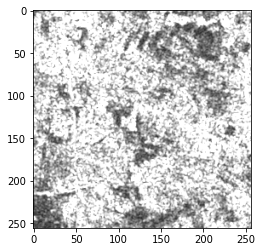

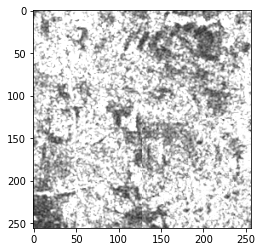

NameError: name 'compare_images' is not defined

In [23]:
from train import *
import networks2
from scipy import spatial

metric = 'cosine'

#check resullts
def generate_image(im, cvae_model=None, gen_model=None, lod_in=0.0, size=256):
    size = int(size/2)
    im = adjust_dynamic_range(im, [0,255], [-1,1])
    #im= im[:,:, :(size),:(size)]
    #im= np.transpose(im, (2, 0, 1))

    batch = np.zeros((1, 1, size*2, size*2))
    batch[0] = im
    #batch = batch[:,:, :(size),:(size)]


    corner1= batch[:,:, :(size),:(size)]
    corner2= batch[:,:, (size):,:(size)]
    corner3= batch[:,:, :(size),(size):]
    original_corner= batch[:,:, (size):,(size):]


    noise_shape = 2048

     #generate noise image
    latents = tf.random.normal([1, noise_shape])

    ae_latent1 = cvae_model.encode(corner1)
    ae_latent2 = cvae_model.encode(corner2)
    ae_latent3 = cvae_model.encode(corner3)

    #check axis
    ae_latent_left = tf.concat([ae_latent1, ae_latent2], axis=1)
    ae_latents = tf.concat([ae_latent_left, ae_latent3], axis=1)

    corner4 = tf.cast(gen_model([latents, ae_latents, lod_in], training=False), tf.float32) 

    image_right = tf.cast(tf.concat([corner3, corner4], axis=2), tf.float32)
    image_left = tf.cast(tf.concat([corner1, corner2], axis=2), tf.float32)
    image_full = tf.concat([image_left, image_right], axis=3)

    predictions = image_full.numpy()
    original_corner = original_corner[0]
    corner4 = corner4.numpy()[0]

    grid_fakes = predictions[0]

    grid_fakes = adjust_dynamic_range(grid_fakes, [-1,1], [0,255])
    original_corner = adjust_dynamic_range(original_corner, [-1,1], [0,255])
    corner4 = adjust_dynamic_range(corner4, [-1,1], [0,255])
    
    grid = grid_fakes#.transpose(1, 2, 0) # CHW -> HWC

    return grid, original_corner, corner4

def snapshot(datapath, resolution_log2=256, n_images=1, save=False):
    tfrecord_dir = datapath
    tfr_files = sorted(glob.glob(os.path.join(tfrecord_dir, '*.tfrecords')))
    minibatch_base = 32
    minibatch_dict = {4: 1024, 8: 512, 16: 256, 32: 64, 64: 64, 128: 32}
    max_minibatch_per_gpu = {256: 16, 512: 8, 1024: 8}
    dataset_list, batch_sizes_list = get_dataset(tfr_files, flood=True, num_gpus=1, minibatch_base = minibatch_base, minibatch_dict = minibatch_dict, max_minibatch_per_gpu = max_minibatch_per_gpu)
    lod_dataset = int(np.log2(256)) - int(np.log2(resolution_log2))
    dataset = dataset_list[lod_dataset]
    print(dataset)
    print(lod_dataset)

    dataset_iter = iter(dataset)
    images = []


    for _ in range(n_images):
        dataset_el = tf.cast(next(dataset_iter).numpy()[0], tf.float32) 
        images.append(dataset_el)

    if save:
        format = 'RGB' #if image.ndim == 3 else 'L'
        image = Image.fromarray(dataset, format).save('img.png')
    
    return images

resolution = 256

#generator_4480

gen = networks2.generator(resolution, num_channels=1, num_replicas = 1)
gen.load_weights('/data/redacost/myCProGan/generator_Final.h5', by_name=True)
#gen.load_weights('/data/redacost/myCProGan/saved_models/generator_4480.h5', by_name=True)
#os.remove('generator.h5') 

#disc.save_weights('discriminator.h5')
# disc = networks2.Combined_Discriminator(resolution, num_channels=1, num_replicas = num_replicas)
# disc.built = True
# disc.load_weights('saved_models/discriminator_'+str(load_current_image)+'.h5', by_name=True)
#os.remove('discriminator.h5') 

cvae = networks2.CVAE(resolution=resolution, base_filter=int(32*(256/resolution)),latent_dim=2048,num_channels=1)
cvae.built = True #subcalssed model needs to be built use tf format instead of hdf5 might solve the problem
cvae.load_weights('/data/redacost/myCProGan/saved_models/vae/cvae_models/cvae_Final_'+str(resolution)+'.h5')

n_img = 2
lod=0

images = snapshot('/eos/user/r/redacost/progan/floods/test_floods', resolution_log2=resolution, n_images=n_img)

for i in range(n_img):
    plt.imshow(images[0][0], cmap='gray', vmin=0, vmax=255)
    plt.show()
    data, original_corner, generated_corner = generate_image(images[0], cvae_model=cvae, gen_model=gen, lod_in=lod,size=resolution)
    plt.imshow(data[0], cmap='gray', vmin=0, vmax=255)
    plt.show()
    compare_images(original_corner[0], generated_corner[0],1)
    if i > 0:
        compare_images(prev_image[0], generated_corner[0],0)
    prev_image=generated_corner
    #similarity = 1 - spatial.distance.cosine(original_corner[0], generated_corner[0])
    #print(similarity)

#     cosineDistance = distance.cdist(original_corner[0], generated_corner[0], metric)[0]
#     print(cosineDistance)
#     print("the distance between cat and the rocket is {}".format(cosineDistance))

In [ ]:
from scipy.spatial import distance
metric = 'cosine'
cosineDistance = distance.cdist([cat], [rocket], metric)[0]
print(cosineDistance)
print("the distance between cat and the rocket is {}".format(cosineDistance))

## Losses

### Loss

In [2]:
with open("losses.pkl", "rb") as input_file:
    losses = pickle.load(input_file)

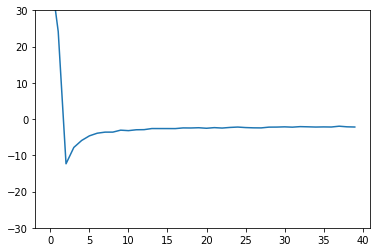

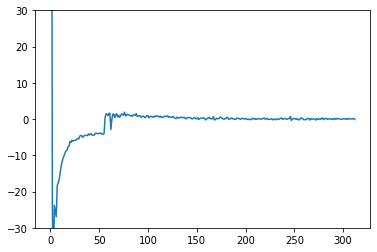

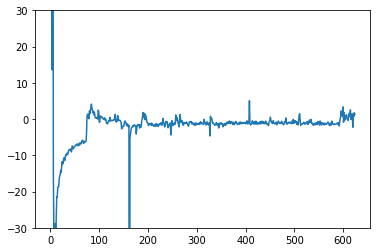

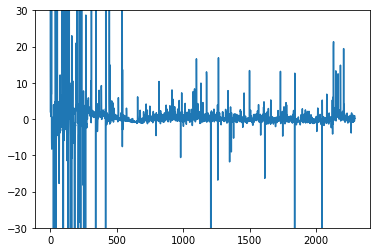

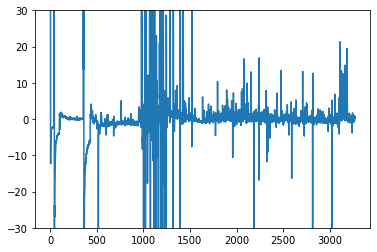

In [14]:
gen_losses = losses['gen_loss']

#print(len(gen_losses))

#print(gen_losses)

gen_losses_32 = [] #128
gen_losses_64 = [] #64
gen_losses_128 = [] #32
gen_losses_256 = [] #16

new_gen_losses_32 = []
new_gen_losses_64 = []
new_gen_losses_128 = []
new_gen_losses_256 = []

for i in range(len(gen_losses)):
    if i < 3907:
        gen_losses_32.append(gen_losses[i])
    elif i < 35156:
        gen_losses_64.append(gen_losses[i])
    elif i < 97656: 
        gen_losses_128.append(gen_losses[i])
    else: 
        gen_losses_256.append(gen_losses[i])


buffer = []

for i in range(len(gen_losses_32)):
    buffer.append(gen_losses_32[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_32.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_32.append(avg)
       #ew_gen_losses_32.append(gen_losses_32[i])

buffer = []

for i in range(len(gen_losses_64)):
    # if i % 10 == 0:
    #    new_gen_losses_64.append(gen_losses_64[i])
    buffer.append(gen_losses_64[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_64.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_64.append(avg)

buffer = []

for i in range(len(gen_losses_128)):
#     if i % 10 == 0:
#        new_gen_losses_128.append(gen_losses_128[i])
    buffer.append(gen_losses_128[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_128.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_128.append(avg)

buffer = []

for i in range(len(gen_losses_256)):
#     if i % 100 == 0:
#        new_gen_losses_256.append(gen_losses_256[i])
    buffer.append(gen_losses_256[i])
    if i % 100 == 0:
        if i ==0:
            new_gen_losses_256.append(buffer[i])
        else:
            avg = sum(buffer) / 100
            buffer = []
            new_gen_losses_256.append(avg)

new_gen_losses = new_gen_losses_32 + new_gen_losses_64 + new_gen_losses_128 + new_gen_losses_256

plt.ylim([-30, 30])

plt.plot(new_gen_losses_32)
plt.show()

plt.ylim([-30, 30])

plt.plot(new_gen_losses_64)
plt.show()

plt.ylim([-30, 30])

plt.plot(new_gen_losses_128)
plt.show()

plt.ylim([-30, 30])

plt.plot(new_gen_losses_256)
plt.show()

plt.ylim([-30, 30])

plt.plot(new_gen_losses)
plt.show()

## Image completion

### Tile

(21601, 29409)
[[218 208 194 ... 235 176 173]
 [204 208 175 ... 191 156 174]
 [219 204 202 ... 151 165 198]
 ...
 [ 57  40  51 ... 106 135 132]
 [ 55  60  68 ... 174 159 138]
 [ 64  72  65 ... 138 126 137]]


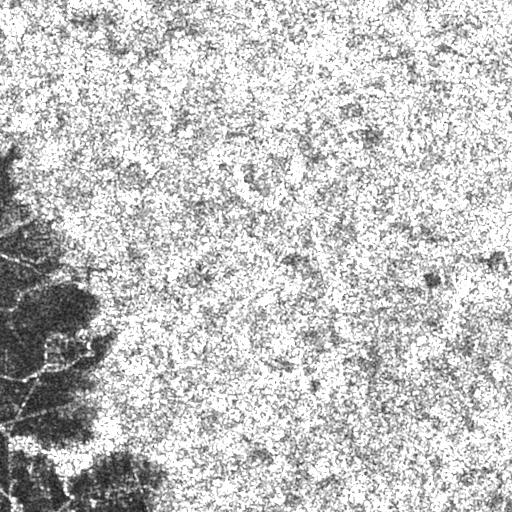

In [3]:
import PIL
from PIL import Image
import numpy

PIL.Image.MAX_IMAGE_PIXELS = 933120000

im = Image.open('/eos/user/r/redacost/Flood_Dataset/S1A_20160805T114607_ACBC_Orb_TC_compressed.tif')

imarray = numpy.array(im)

print(imarray.shape)

height = imarray.shape[0]
width = imarray.shape[1]

half_height = height//2
half_width = width//2

tyle = imarray[half_height:half_height+512,half_width:half_width+512]

print(tyle)

img_tyle = Image.fromarray(tyle)

img_tyle.show()

### Image completion

Model: "functional_85"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent (InputLayer)             [(None, 2048)]       0                                            
__________________________________________________________________________________________________
ae_latent (InputLayer)          [(None, 6144)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_7 (TensorFlo [(None, 8192)]       0           latent[0][0]                     
                                                                 ae_latent[0][0]                  
__________________________________________________________________________________________________
pixel_norm_layer_91 (Pixel_norm (None, 8192)         0           tf_op_layer_concat_7[

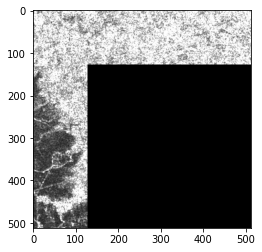

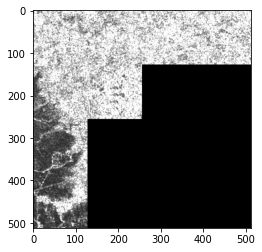

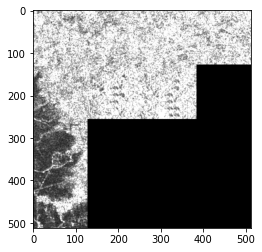

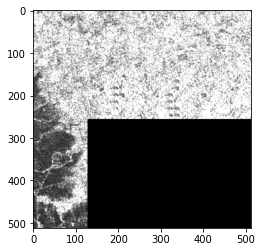

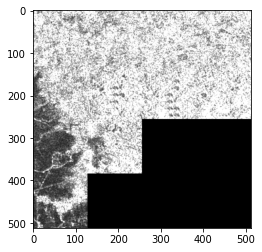

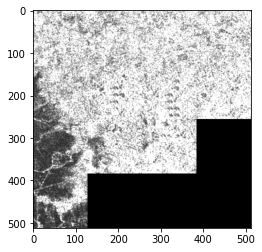

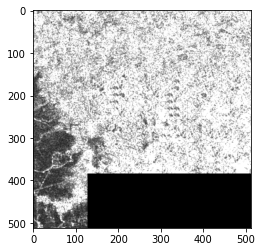

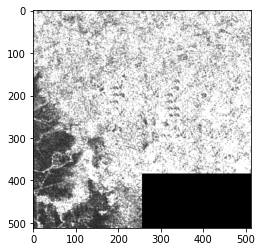

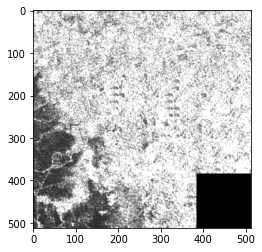

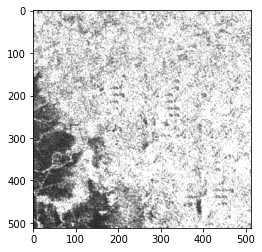

In [26]:
from train import *
import networks2
from scipy import spatial

metric = 'cosine'

#check resullts
def generate_image(im, cvae_model=None, gen_model=None, lod_in=0.0, size=256):
    size = int(size/2)
    im = adjust_dynamic_range(im, [0,255], [-1,1])
    #im= im[:,:, :(size),:(size)]
    #im= np.transpose(im, (2, 0, 1))

    batch = np.zeros((1, 1, size*2, size*2))
    batch[0] = im
    #batch = batch[:,:, :(size),:(size)]


    corner1= batch[:,:, :(size),:(size)]
    corner2= batch[:,:, (size):,:(size)]
    corner3= batch[:,:, :(size),(size):]
    original_corner= batch[:,:, (size):,(size):]


    noise_shape = 2048

     #generate noise image
    latents = tf.random.normal([1, noise_shape])

    ae_latent1 = cvae_model.encode(corner1)
    ae_latent2 = cvae_model.encode(corner2)
    ae_latent3 = cvae_model.encode(corner3)

    #check axis
    ae_latent_left = tf.concat([ae_latent1, ae_latent2], axis=1)
    ae_latents = tf.concat([ae_latent_left, ae_latent3], axis=1)

    corner4 = tf.cast(gen_model([latents, ae_latents, lod_in], training=False), tf.float32) 

    image_right = tf.cast(tf.concat([corner3, corner4], axis=2), tf.float32)
    image_left = tf.cast(tf.concat([corner1, corner2], axis=2), tf.float32)
    image_full = tf.concat([image_left, image_right], axis=3)

    predictions = image_full.numpy()
    original_corner = original_corner[0]
    corner4 = corner4.numpy()[0]

    grid_fakes = predictions[0]

    grid_fakes = adjust_dynamic_range(grid_fakes, [-1,1], [0,255])
    original_corner = adjust_dynamic_range(original_corner, [-1,1], [0,255])
    corner4 = adjust_dynamic_range(corner4, [-1,1], [0,255])
    
    grid = grid_fakes#.transpose(1, 2, 0) # CHW -> HWC

    return grid, original_corner, corner4

# def snapshot(datapath, resolution_log2=256, n_images=1, save=False):
#     tfrecord_dir = datapath
#     tfr_files = sorted(glob.glob(os.path.join(tfrecord_dir, '*.tfrecords')))
#     minibatch_base = 32
#     minibatch_dict = {4: 1024, 8: 512, 16: 256, 32: 64, 64: 64, 128: 32}
#     max_minibatch_per_gpu = {256: 16, 512: 8, 1024: 8}
#     dataset_list, batch_sizes_list = get_dataset(tfr_files, flood=True, num_gpus=1, minibatch_base = minibatch_base, minibatch_dict = minibatch_dict, max_minibatch_per_gpu = max_minibatch_per_gpu)
#     lod_dataset = int(np.log2(256)) - int(np.log2(resolution_log2))
#     dataset = dataset_list[lod_dataset]
#     print(dataset)
#     print(lod_dataset)

#     dataset_iter = iter(dataset)
#     images = []


#     for _ in range(n_images):
#         dataset_el = tf.cast(next(dataset_iter).numpy()[0], tf.float32) 
#         images.append(dataset_el)

#     if save:
#         format = 'RGB' #if image.ndim == 3 else 'L'
#         image = Image.fromarray(dataset, format).save('img.png')
    
#     return images

resolution = 256

#generator_4480

gen = networks2.generator(resolution, num_channels=1, num_replicas = 1)
gen.load_weights('/data/redacost/myCProGan/generator_Final.h5', by_name=True)
#gen.load_weights('/data/redacost/myCProGan/saved_models/generator_4480.h5', by_name=True)
#os.remove('generator.h5') 

#disc.save_weights('discriminator.h5')
# disc = networks2.Combined_Discriminator(resolution, num_channels=1, num_replicas = num_replicas)
# disc.built = True
# disc.load_weights('saved_models/discriminator_'+str(load_current_image)+'.h5', by_name=True)
#os.remove('discriminator.h5') 

cvae = networks2.CVAE(resolution=resolution, base_filter=int(32*(256/resolution)),latent_dim=2048,num_channels=1)
cvae.built = True #subcalssed model needs to be built use tf format instead of hdf5 might solve the problem
cvae.load_weights('/data/redacost/myCProGan/saved_models/vae/cvae_models/cvae_Final_'+str(resolution)+'.h5')

n_img = 3
lod=0

image_x = [tyle[0:256,0:256]]
image_x = tf.cast(image_x, tf.float32) 
images = [image_x]

new_image = numpy.zeros((512,512))
new_image[0:128,0:512] = tyle[0:128,0:512]
new_image[0:512,0:128] = tyle[0:512,0:128]

plt.imshow(new_image, cmap='gray', vmin=0, vmax=255)
plt.show()


# images = snapshot('/eos/user/r/redacost/progan/floods/test_floods', resolution_log2=resolution, n_images=n_img)

for i in range(n_img):
    for j in range(n_img):     
        image = [new_image[i*128:256+i*128,128*j:256+128*j]]
        image = tf.cast(image, tf.float32)
        data, original_corner, generated_corner = generate_image(image, cvae_model=cvae, gen_model=gen, lod_in=lod,size=resolution)
        new_image[128+i*128:256+i*128,128+128*j:256+128*j] = generated_corner[0]
        plt.imshow(new_image, cmap='gray', vmin=0, vmax=255)
        plt.show()

### Dataset Generation

(21601, 29409)


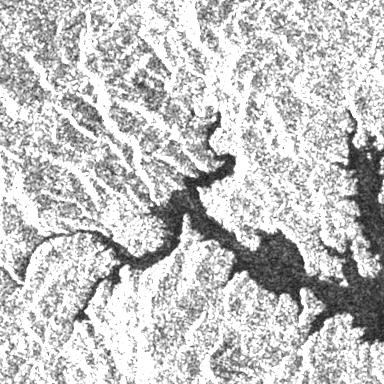

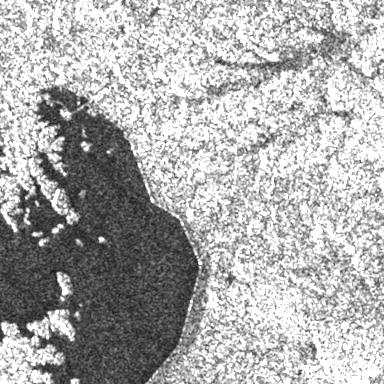

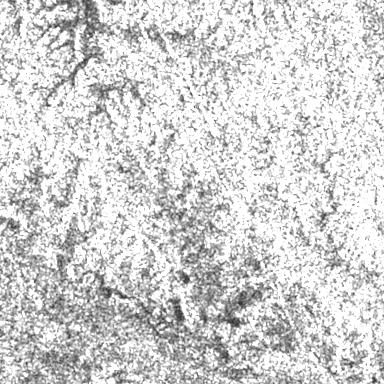

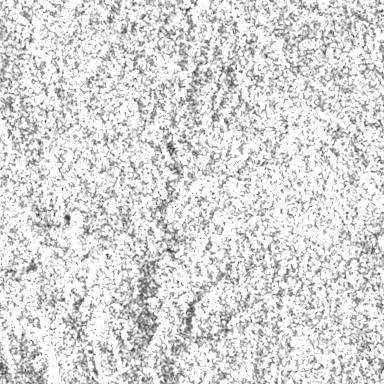

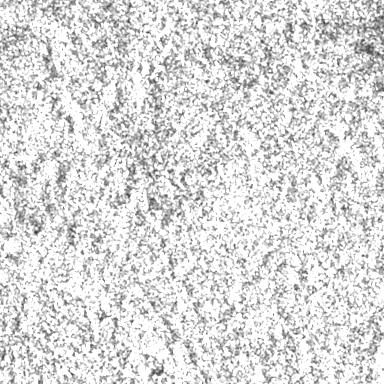

Model: "functional_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent (InputLayer)             [(None, 2048)]       0                                            
__________________________________________________________________________________________________
ae_latent (InputLayer)          [(None, 6144)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_5 (TensorFlo [(None, 8192)]       0           latent[0][0]                     
                                                                 ae_latent[0][0]                  
__________________________________________________________________________________________________
pixel_norm_layer_65 (Pixel_norm (None, 8192)         0           tf_op_layer_concat_5[

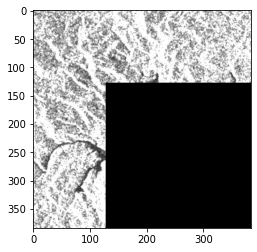

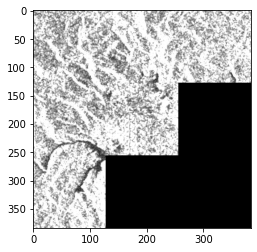

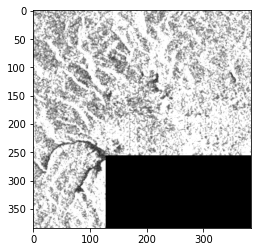

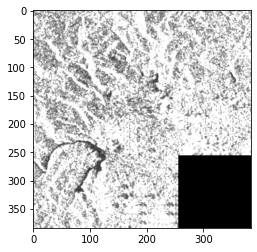

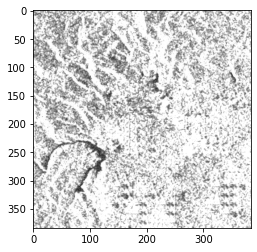

1


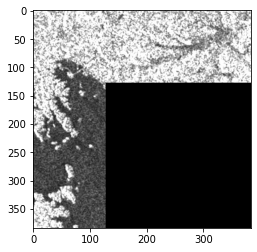

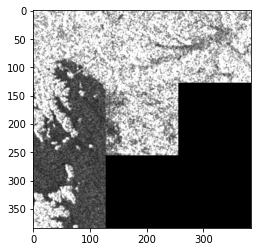

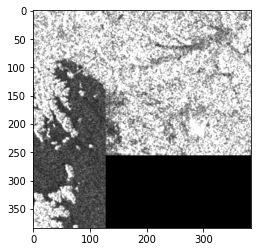

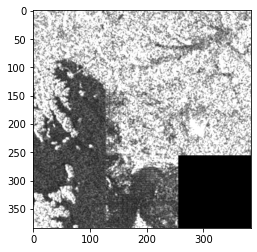

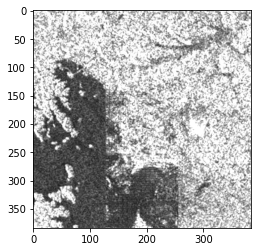

2


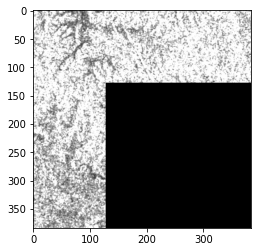

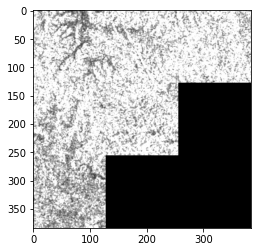

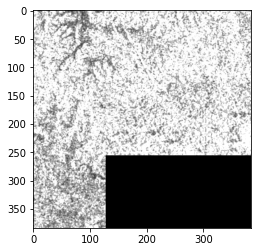

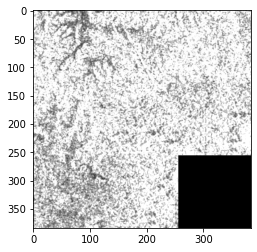

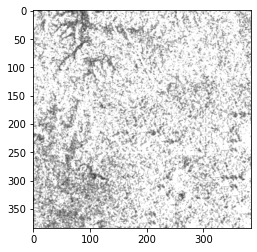

3


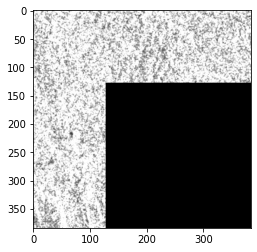

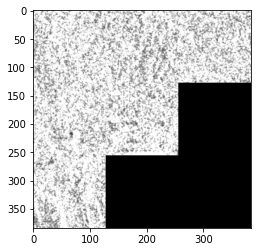

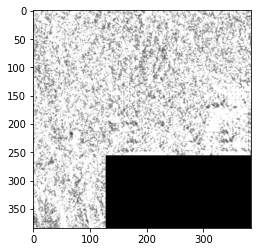

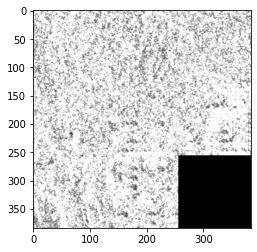

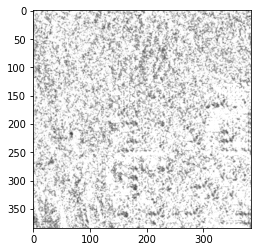

4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
27

In [10]:
from train import *
import networks2
from scipy import spatial

import PIL
from PIL import Image
import numpy

final_res = 384

PIL.Image.MAX_IMAGE_PIXELS = 933120000

im = Image.open('/eos/user/r/redacost/Flood_Dataset/S1A_20160805T114607_ACBC_Orb_TC_compressed.tif')
imarray = numpy.array(im)
print(imarray.shape)

tyle_list = []

height = imarray.shape[0]
width = imarray.shape[1]
half_height = height//2
half_width = width//2

num_tyles_height = 15
num_tyles_width = 20

start_height = half_height - num_tyles_height * final_res
start_width = half_width - num_tyles_width * final_res

for h in range(num_tyles_height):
    for w in range(num_tyles_width):
        tyle = imarray[start_height + h*final_res:start_height + h*final_res + final_res, start_width + w*final_res:start_width + w*final_res + final_res]
        tyle_list.append(tyle)

        if h == 0 and w < 5:
            img_tyle = Image.fromarray(tyle)
            img_tyle.show()


#check resullts
def generate_image(im, cvae_model=None, gen_model=None, lod_in=0.0, size=256):
    size = int(size/2)
    im = adjust_dynamic_range(im, [0,255], [-1,1])
    #im= im[:,:, :(size),:(size)]
    #im= np.transpose(im, (2, 0, 1))

    batch = np.zeros((1, 1, size*2, size*2))
    batch[0] = im
    #batch = batch[:,:, :(size),:(size)]


    corner1= batch[:,:, :(size),:(size)]
    corner2= batch[:,:, (size):,:(size)]
    corner3= batch[:,:, :(size),(size):]
    original_corner= batch[:,:, (size):,(size):]


    noise_shape = 2048

     #generate noise image
    latents = tf.random.normal([1, noise_shape])

    ae_latent1 = cvae_model.encode(corner1)
    ae_latent2 = cvae_model.encode(corner2)
    ae_latent3 = cvae_model.encode(corner3)

    #check axis
    ae_latent_left = tf.concat([ae_latent1, ae_latent2], axis=1)
    ae_latents = tf.concat([ae_latent_left, ae_latent3], axis=1)

    corner4 = tf.cast(gen_model([latents, ae_latents, lod_in], training=False), tf.float32) 

    image_right = tf.cast(tf.concat([corner3, corner4], axis=2), tf.float32)
    image_left = tf.cast(tf.concat([corner1, corner2], axis=2), tf.float32)
    image_full = tf.concat([image_left, image_right], axis=3)

    predictions = image_full.numpy()
    original_corner = original_corner[0]
    corner4 = corner4.numpy()[0]

    grid_fakes = predictions[0]

    grid_fakes = adjust_dynamic_range(grid_fakes, [-1,1], [0,255])
    original_corner = adjust_dynamic_range(original_corner, [-1,1], [0,255])
    corner4 = adjust_dynamic_range(corner4, [-1,1], [0,255])
    
    grid = grid_fakes#.transpose(1, 2, 0) # CHW -> HWC

    return grid, original_corner, corner4

# def snapshot(datapath, resolution_log2=256, n_images=1, save=False):
#     tfrecord_dir = datapath
#     tfr_files = sorted(glob.glob(os.path.join(tfrecord_dir, '*.tfrecords')))
#     minibatch_base = 32
#     minibatch_dict = {4: 1024, 8: 512, 16: 256, 32: 64, 64: 64, 128: 32}
#     max_minibatch_per_gpu = {256: 16, 512: 8, 1024: 8}
#     dataset_list, batch_sizes_list = get_dataset(tfr_files, flood=True, num_gpus=1, minibatch_base = minibatch_base, minibatch_dict = minibatch_dict, max_minibatch_per_gpu = max_minibatch_per_gpu)
#     lod_dataset = int(np.log2(256)) - int(np.log2(resolution_log2))
#     dataset = dataset_list[lod_dataset]
#     print(dataset)
#     print(lod_dataset)

#     dataset_iter = iter(dataset)
#     images = []


#     for _ in range(n_images):
#         dataset_el = tf.cast(next(dataset_iter).numpy()[0], tf.float32) 
#         images.append(dataset_el)

#     if save:
#         format = 'RGB' #if image.ndim == 3 else 'L'
#         image = Image.fromarray(dataset, format).save('img.png')
    
#     return images

resolution = 256

#generator_4480

gen = networks2.generator(resolution, num_channels=1, num_replicas = 1)
gen.load_weights('/data/redacost/myCProGan/generator_Final.h5', by_name=True)
#gen.load_weights('/data/redacost/myCProGan/saved_models/generator_4480.h5', by_name=True)
#os.remove('generator.h5') 

#disc.save_weights('discriminator.h5')
# disc = networks2.Combined_Discriminator(resolution, num_channels=1, num_replicas = num_replicas)
# disc.built = True
# disc.load_weights('saved_models/discriminator_'+str(load_current_image)+'.h5', by_name=True)
#os.remove('discriminator.h5') 

cvae = networks2.CVAE(resolution=resolution, base_filter=int(32*(256/resolution)),latent_dim=2048,num_channels=1)
cvae.built = True #subcalssed model needs to be built use tf format instead of hdf5 might solve the problem
cvae.load_weights('/data/redacost/myCProGan/saved_models/vae/cvae_models/cvae_Final_'+str(resolution)+'.h5')

n_img = 2
lod=0

tyle_count = 0

h = 0
w = 0


for tyle in tyle_list:
    print(tyle_count)
    
    tyle_count+=1
    new_image = numpy.zeros((final_res,final_res))
    new_image[0:128,0:final_res] = tyle[0:128,0:final_res]
    new_image[0:final_res,0:128] = tyle[0:final_res,0:128]
    
    new_tyle = numpy.zeros((256,256))

    if tyle_count < 5:
        plt.imshow(new_image, cmap='gray', vmin=0, vmax=255)
        plt.show()
    for i in range(n_img):
        for j in range(n_img):     
            image = [new_image[i*128:256+i*128,128*j:256+128*j]]
            image = tf.cast(image, tf.float32)
            data, original_corner, generated_corner = generate_image(image, cvae_model=cvae, gen_model=gen, lod_in=lod,size=resolution)
            new_image[128+i*128:256+i*128,128+128*j:256+128*j] = generated_corner[0]
            new_tyle[i*128:128+i*128,128*j:128+128*j] = generated_corner[0]
            
            if tyle_count < 5:
                    plt.imshow(new_image, cmap='gray', vmin=0, vmax=255)
                    plt.show()
                
    image = np.rint(new_tyle).clip(0, 255).astype(np.uint8)
    format = 'L'
    image = Image.fromarray(image, format).save('/eos/user/r/redacost/flood_generated_dataset/Myanmar_old/tile_'+str(h)+'_'+str(w)+'.png')
     
    w += 1
    if w >= num_tyles_width:
        w = 0
        h += 1
    

print(tyle_count)

# images = snapshot('/eos/user/r/redacost/progan/floods/test_floods', resolution_log2=resolution, n_images=n_img)

## Validation

### Inception Score

In [80]:
import cv2 
from tensorflow.keras.layers import Input, Conv2D
from numpy import *
from skimage.transform import rescale, resize, downscale_local_mean


n_img = 100

images = snapshot('/eos/user/r/redacost/progan/floods/test_floods', resolution_log2=resolution, n_images=n_img)
batch = gray_to_rgb(images)

def gray_to_rgb(images):
    batch = np.zeros((n_img,128, 128, 3))
    i = 0
    #(n_img,128, 128, 3)
    for image in images:
        img = image[0][128:256,128:256]
        imgray = img.numpy()

        img2 = np.zeros((128,128,3))
        img2[:,:,0] = imgray
        img2[:,:,1] = imgray
        img2[:,:,2] = imgray

        batch[i] = img2

        i +=1
        
    return batch


height = 128
width=128

inception= tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,#Input(shape=(3, height,width)),
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

print(inception.summary())

inception.trainable = False

# input_tensor = Input(shape=(1, height,width))
# x = Conv2D(3,(3,3),padding='same', data_format='channels_first')(input_tensor)    # x has a dimension of (img_height,img_width,3)
# out1 = inception(x)
# #out = Dense(10, activation = 'softmax')(out1)

# model = Model(inputs = input_tensor, outputs = out1)

#print(inception.summary())

def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

def calculate_inception_score(p_yx, eps=1E-8):
	# calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    print(p_y.shape)
	# kl divergence for each image
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
	# sum over classes
    sum_kl_d = kl_d.sum(axis=1)
	# average over images
    avg_kl_d = mean(sum_kl_d)
	# undo the logs
    is_score = exp(avg_kl_d)
    return is_score

def calculate(images_predict):
    batch = scale_images(images_predict, (299,299,3))
    #batch[0] = images_predict
    print(batch.shape)
    inception_predict = inception(batch).numpy()
    scores = list()
    print(inception_predict)
    #n_part = floor(images.shape[0] / n_split)
	#for i in range(n_split):
		# retrieve p(y|x)
    #ix_start, ix_end = i * n_part, i * n_part + n_part
    p_yx = inception_predict
    is_score = calculate_inception_score(p_yx)
    scores.append(is_score)
	# average across images
    is_avg, is_std = mean(scores), std(scores)
    return is_avg, is_std

print(calculate(batch))



[(1, 4, 4), (1, 8, 8), (1, 16, 16), (1, 32, 32), (1, 64, 64), (1, 128, 128), (1, 256, 256)]
[6, 5, 4, 3, 2, 1, 0]
{6: 1024, 5: 512, 4: 256, 3: 64, 2: 64, 1: 32, 0: 16}
Dataset Read
<BatchDataset shapes: (None, 1, None, None), types: tf.uint8>
0
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3674 (Conv2D)            (None, 149, 149, 32) 864         input_47[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3668 (Batch (None, 149, 149, 32) 96          conv2d_3674[0][0]                
________________________________________

### Frechet Inception Distance

In [ ]:
import cv2 
from tensorflow.keras.layers import Input, Conv2D
from numpy import *
from skimage.transform import rescale, resize, downscale_local_mean


n_img = 100
resolution = 256


images = snapshot('/eos/user/r/redacost/progan/floods/test_floods', resolution_log2=resolution, n_images=n_img)
batch = gray_to_rgb(images)

def gray_to_rgb(images):
    batch = np.zeros((n_img,128, 128, 3))
    i = 0
    #(n_img,128, 128, 3)
    for image in images:
        img = image[0][128:256,128:256]
        imgray = img.numpy()

        img2 = np.zeros((128,128,3))
        img2[:,:,0] = imgray
        img2[:,:,1] = imgray
        img2[:,:,2] = imgray

        batch[i] = img2

        i +=1
        
    return batch


height = 128
width=128

inception= tf.keras.applications.inception_v3.InceptionV3(
    include_top=True,
    weights='imagenet',
    input_tensor=None,#Input(shape=(3, height,width)),
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

print(inception.summary())

inception.trainable = False


def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model(images1)
	act2 = model(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

gen = networks2.generator(resolution, num_channels=1, num_replicas = 1)
gen.load_weights('/data/redacost/myCProGan/generator_Final.h5', by_name=True)
cvae = networks2.CVAE(resolution=resolution, base_filter=int(32*(256/resolution)),latent_dim=2048,num_channels=1)
cvae.built = True #subcalssed model needs to be built use tf format instead of hdf5 might solve the problem
cvae.load_weights('/data/redacost/myCProGan/saved_models/vae/cvae_models/cvae_Final_'+str(resolution)+'.h5')


lod=0
batch_corners = np.zeros((n_img,128, 128, 3))
batch = gray_to_rgb(images)

generated_images = []

for image in images:
    data, original_corner, generated_corner = generate_image(image, cvae_model=cvae, gen_model=gen, lod_in=lod,size=resolution)
    